

[参考文档](https://blog.csdn.net/weixin_46969441/article/details/121043572?ops_request_misc=&request_id=&biz_id=102&utm_term=%E6%B7%B1%E5%BA%A6%E5%AD%A6%E4%B9%A0%E7%A4%BA%E4%BE%8B&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduweb~default-2-121043572.142^v99^pc_search_result_base1&spm=1018.2226.3001.4187)

通过该文档，可以学到：

1. epoch，batch_size和iteration区分
2. 


构建和训练一个基于TensorFlow的机器学习模型，具体用于处理鸢尾花（Iris）数据集。这个数据集包含了150个鸢尾花样本，每个样本有4个特征和一个标签（共有三种鸢尾花类别）

全连接神经网络

# 查看数据样式

In [28]:
from sklearn import datasets
from pandas import DataFrame
import pandas as pd

# .data返回iris数据集所有输入特征
x_data = datasets.load_iris().data 
y_data = datasets.load_iris().target
# .target返回iris数据集所有标签  

 # 为表格增加行索引（左侧）和列标签（上方）
x_data = DataFrame(x_data, columns=['花萼长度', '花萼宽度', '花瓣长度', '花瓣宽度'])
# 设置列名对齐
pd.set_option('display.unicode.east_asian_width', True)  
# 新加一列，列标签为‘类别’，数据为y_data
x_data['类别'] = y_data  
x_data.head(10)


,花萼长度,花萼宽度,花瓣长度,花瓣宽度,类别
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0
7,5.0,3.4,1.5,0.2,0
8,4.4,2.9,1.4,0.2,0
9,4.9,3.1,1.5,0.1,0


# 数据预处理

1.划分训练集和验证集

2.转换数据格式

3.采用batch策略



In [31]:
#这段代码主要是数据的准备和预处理过程，为接下来建立神经网络模型并进行训练做准备。

# 导入所需模块
import tensorflow as tf
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np
 
# 导入数据，分别为输入特征和标签
x_data = datasets.load_iris().data
y_data = datasets.load_iris().target
 
# 随机打乱数据（因为原始数据是顺序的，顺序不打乱会影响准确率）
# seed: 随机数种子，是一个整数，当设置之后，每次生成的随机数都一样（为方便教学，以保每位同学结果一致）
np.random.seed(16)  # 使用相同的seed，保证输入特征和标签一一对应
np.random.shuffle(x_data)
np.random.seed(16)
np.random.shuffle(y_data)
tf.random.set_seed(16)
 
# 将打乱后的数据集分割为训练集和测试集，训练集为前120行，测试集为后30行
x_train = x_data[:-30]
y_train = y_data[:-30]
x_test = x_data[-30:]
y_test = y_data[-30:]


# 数据类型转换，将特征数据的类型转换为TensorFlow可处理的浮点数格式。
# 转换x的数据类型，否则后面矩阵相乘时会因数据类型不一致报错
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)
 
# from_tensor_slices函数使输入特征和标签值一一对应。（把数据集分批次，每个批次batch组数据）
# 将数据切片，每个批次包含32个数据点。这样可以在模型训练时提供批量数据，有助于提高训练效率。
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)


# 搭建神经网络

1.创建两个变量 w1 和 b1。其中，w1 是一个形状为 [4, 3] 的张量，b1 是一个形状为 [3] 的张量。这些变量通常用于神经网络模型的权重和偏置项。
2.设置超参数

In [32]:

# 生成神经网络的参数w1和b1，4个输入特征，输入层为4个输入节点；因为3分类，故输出层为3个神经元
# 用tf.Variable()标记参数可训练
# 使用seed使每次生成的随机数相同（方便教学，使大家结果都一致，在现实使用时不写seed）
w1 = tf.Variable(tf.random.truncated_normal([4, 3], stddev=0.1, seed=1))
b1 = tf.Variable(tf.random.truncated_normal([3], stddev=0.1, seed=1))


In [33]:
lr = 0.01  # 定义学习率
test_acc = []  # 初始化测试准确率列表
train_loss_results = []  # 初始化训练损失值列表

epochs = 500  # 定义循环的总次数
for epoch in range(epochs):  # 数据集别的 循环，每个epoch循环一次数据集
    loss_all = 0
    for step, (x_train, y_train) in enumerate(train_db):  # batch级别 的循环
        with tf.GradientTape() as tape:  # with结构记录梯度信息
            # 构建神经元
            y = tf.matmul(x_train, w1) + b1  # 神经网络 乘加运算
            y = tf.nn.softmax(y)  # 使输出y符合概率分布（此操作后与独热码同量级，可相减求loss）
            y_ = tf.one_hot(y_train, depth=3)  # 将标签值转换为独热码格式，方便计算loss和accuracy
            loss = tf.reduce_mean(tf.square(y_ - y))  # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss_all += loss.numpy()  # 将每个step计算出的loss累加，为后续求loss平均值提供数据，这样计算的loss更准确
            # 根据损失函数计算梯度，进行梯度下降
            grads = tape.gradient(loss, [w1, b1])
            # 实现梯度更新 w1 = w1 - lr * w1_grad    b = b - lr * b_grad
            w1.assign_sub(lr * grads[0])  # 参数w1自更新
            b1.assign_sub(lr * grads[1])  # 参数b自更新

    # 计算每个epoch的平均损失并存储
    average_loss = loss_all / len(train_db)
    train_loss_results.append(average_loss)
    print("Epoch {}, loss: {}".format(epoch, average_loss))

    # 在每个epoch结束时，计算测试集的准确率
    total_correct = 0
    total_number = 0
    for x_test, y_test in test_db:
        # 使用更新后的参数进行测试
        y = tf.matmul(x_test, w1) + b1
        y = tf.nn.softmax(y)
        pred = tf.argmax(y, axis=1)  # 返回y中最大值的索引，即预测的分类
        pred = tf.cast(pred, dtype=y_test.dtype)  # 调整数据类型和标签一致
        correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
        correct = tf.reduce_sum(correct)
        total_correct += int(correct)
        total_number += x_test.shape[0]

    # 计算并存储每个epoch的测试准确率
    epoch_acc = total_correct / total_number
    test_acc.append(epoch_acc)
    print("Epoch {}, Test accuracy: {}".format(epoch, epoch_acc))

print("--------------------------")




Epoch 0, loss: 0.2643422596156597
Epoch 0, Test accuracy: 0.2
Epoch 1, loss: 0.2535202130675316
Epoch 1, Test accuracy: 0.06666666666666667
Epoch 2, loss: 0.24558036029338837
Epoch 2, Test accuracy: 0.03333333333333333
Epoch 3, loss: 0.239726260304451
Epoch 3, Test accuracy: 0.03333333333333333
Epoch 4, loss: 0.23530928045511246
Epoch 4, Test accuracy: 0.0
Epoch 5, loss: 0.23187675327062607
Epoch 5, Test accuracy: 0.1
Epoch 6, loss: 0.22912343591451645
Epoch 6, Test accuracy: 0.23333333333333334
Epoch 7, loss: 0.22684133425354958
Epoch 7, Test accuracy: 0.16666666666666666
Epoch 8, loss: 0.22488632798194885
Epoch 8, Test accuracy: 0.13333333333333333
Epoch 9, loss: 0.22315765172243118
Epoch 9, Test accuracy: 0.1
Epoch 10, loss: 0.22158486396074295
Epoch 10, Test accuracy: 0.1
Epoch 11, loss: 0.22011903673410416
Epoch 11, Test accuracy: 0.1
Epoch 12, loss: 0.218726497143507
Epoch 12, Test accuracy: 0.03333333333333333
Epoch 13, loss: 0.21738430112600327
Epoch 13, Test accuracy: 0.066666

# 绘制loss和accuray曲线

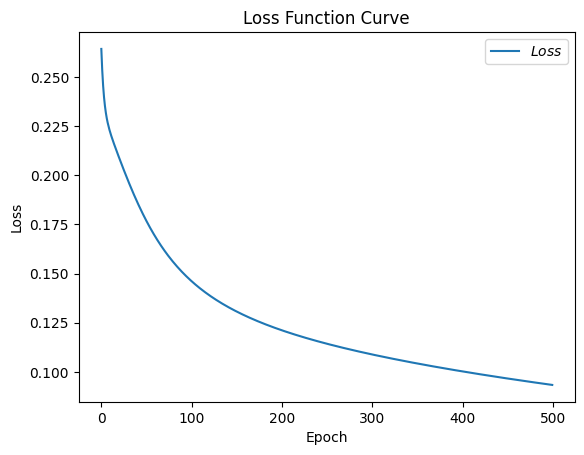

In [34]:
# 绘制 loss 曲线
plt.title('Loss Function Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Loss')  # y轴变量名称
plt.plot(train_loss_results, label="$Loss$")  # 逐点画出trian_loss_results值并连线，连线图标是Loss
plt.legend()  # 画出曲线图标
plt.show()  # 画出图像


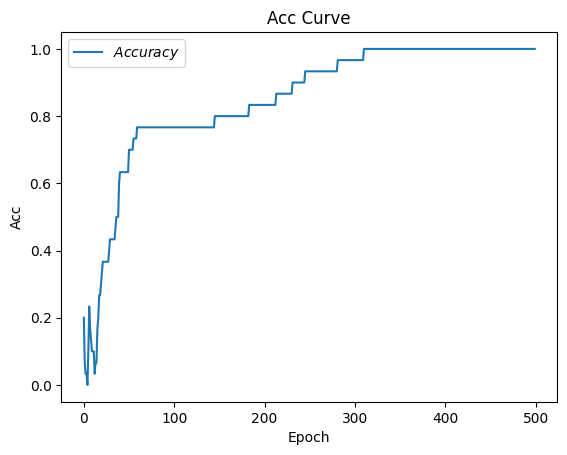

In [35]:
# 绘制 Accuracy 曲线
plt.title('Acc Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Acc')  # y轴变量名称
plt.plot(test_acc, label="$Accuracy$")  # 逐点画出test_acc值并连线，连线图标是Accuracy
plt.legend()
plt.show()


# 精简代码

Epoch 0, loss: 0.2643422596156597
Epoch 0, Test accuracy: 0.2
Epoch 1, loss: 0.2535202130675316
Epoch 1, Test accuracy: 0.06666666666666667
Epoch 2, loss: 0.24558036029338837
Epoch 2, Test accuracy: 0.03333333333333333
Epoch 3, loss: 0.239726260304451
Epoch 3, Test accuracy: 0.03333333333333333
Epoch 4, loss: 0.23530928045511246
Epoch 4, Test accuracy: 0.0
Epoch 5, loss: 0.23187675327062607
Epoch 5, Test accuracy: 0.1
Epoch 6, loss: 0.22912343591451645
Epoch 6, Test accuracy: 0.23333333333333334
Epoch 7, loss: 0.22684133425354958
Epoch 7, Test accuracy: 0.16666666666666666
Epoch 8, loss: 0.22488632798194885
Epoch 8, Test accuracy: 0.13333333333333333
Epoch 9, loss: 0.22315765172243118
Epoch 9, Test accuracy: 0.1
Epoch 10, loss: 0.22158486396074295
Epoch 10, Test accuracy: 0.1
Epoch 11, loss: 0.22011903673410416
Epoch 11, Test accuracy: 0.1
Epoch 12, loss: 0.218726497143507
Epoch 12, Test accuracy: 0.03333333333333333
Epoch 13, loss: 0.21738430112600327
Epoch 13, Test accuracy: 0.066666

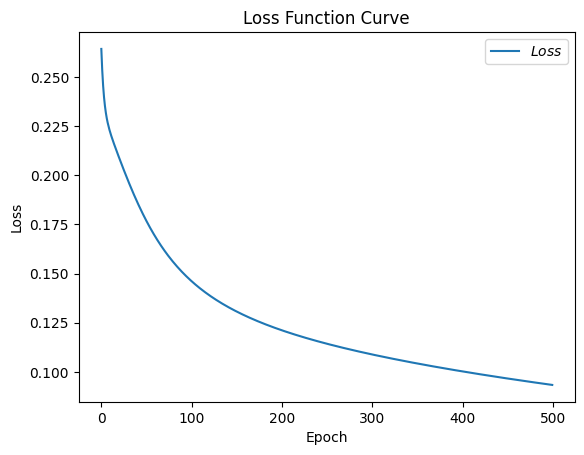

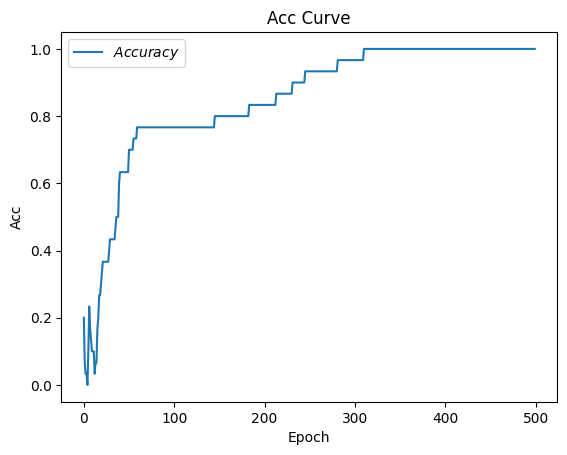

In [27]:
from sklearn import datasets
from pandas import DataFrame
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
 
# 导入数据，分别为输入特征和标签
x_data = datasets.load_iris().data
y_data = datasets.load_iris().target
 
# 随机打乱数据（因为原始数据是顺序的，顺序不打乱会影响准确率）
# seed: 随机数种子，是一个整数，当设置之后，每次生成的随机数都一样（为方便教学，以保每位同学结果一致）
np.random.seed(16)  # 使用相同的seed，保证输入特征和标签一一对应
np.random.shuffle(x_data)
np.random.seed(16)
np.random.shuffle(y_data)
tf.random.set_seed(16)
 
# 将打乱后的数据集分割为训练集和测试集，训练集为前120行，测试集为后30行
x_train = x_data[:-30]
y_train = y_data[:-30]
x_test = x_data[-30:]
y_test = y_data[-30:]


# 数据类型转换，将特征数据的类型转换为TensorFlow可处理的浮点数格式。
# 转换x的数据类型，否则后面矩阵相乘时会因数据类型不一致报错
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)
 
# from_tensor_slices函数使输入特征和标签值一一对应。（把数据集分批次，每个批次batch组数据）
# 将数据切片，每个批次包含32个数据点。这样可以在模型训练时提供批量数据，有助于提高训练效率。
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

w1 = tf.Variable(tf.random.truncated_normal([4, 3], stddev=0.1, seed=1))
b1 = tf.Variable(tf.random.truncated_normal([3], stddev=0.1, seed=1))

lr = 0.01  # 定义学习率
test_acc = []  # 初始化测试准确率列表
train_loss_results = []  # 初始化训练损失值列表

epochs = 500  # 定义循环的总次数
for epoch in range(epochs):  # 数据集别的 循环，每个epoch循环一次数据集
    loss_all = 0
    for step, (x_train, y_train) in enumerate(train_db):  # batch级别 的循环
        with tf.GradientTape() as tape:  # with结构记录梯度信息
            # 构建神经元
            y = tf.matmul(x_train, w1) + b1  # 神经网络 乘加运算
            y = tf.nn.softmax(y)  # 使输出y符合概率分布（此操作后与独热码同量级，可相减求loss）
            y_ = tf.one_hot(y_train, depth=3)  # 将标签值转换为独热码格式，方便计算loss和accuracy
            loss = tf.reduce_mean(tf.square(y_ - y))  # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss_all += loss.numpy()  # 将每个step计算出的loss累加，为后续求loss平均值提供数据，这样计算的loss更准确
            # 根据损失函数计算梯度，进行梯度下降
            grads = tape.gradient(loss, [w1, b1])
            # 实现梯度更新 w1 = w1 - lr * w1_grad    b = b - lr * b_grad
            w1.assign_sub(lr * grads[0])  # 参数w1自更新
            b1.assign_sub(lr * grads[1])  # 参数b自更新

    # 计算每个epoch的平均损失并存储
    average_loss = loss_all / len(train_db)
    train_loss_results.append(average_loss)
    print("Epoch {}, loss: {}".format(epoch, average_loss))

    # 在每个epoch结束时，计算测试集的准确率
    total_correct = 0
    total_number = 0
    for x_test, y_test in test_db:
        # 使用更新后的参数进行测试
        y = tf.matmul(x_test, w1) + b1
        y = tf.nn.softmax(y)
        pred = tf.argmax(y, axis=1)  # 返回y中最大值的索引，即预测的分类
        pred = tf.cast(pred, dtype=y_test.dtype)  # 调整数据类型和标签一致
        correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
        correct = tf.reduce_sum(correct)
        total_correct += int(correct)
        total_number += x_test.shape[0]

    # 计算并存储每个epoch的测试准确率
    epoch_acc = total_correct / total_number
    test_acc.append(epoch_acc)
    print("Epoch {}, Test accuracy: {}".format(epoch, epoch_acc))

print("--------------------------")
# 绘制 loss 曲线
plt.title('Loss Function Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Loss')  # y轴变量名称
plt.plot(train_loss_results, label="$Loss$")  # 逐点画出trian_loss_results值并连线，连线图标是Loss
plt.legend()  # 画出曲线图标
plt.show()  # 画出图像


# 绘制 Accuracy 曲线
plt.title('Acc Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Acc')  # y轴变量名称
plt.plot(test_acc, label="$Accuracy$")  # 逐点画出test_acc值并连线，连线图标是Accuracy
plt.legend()
plt.show()
